In [1]:
from numpy.random import normal
import numpy as np
from numpy.linalg import inv
from numpy.linalg import det

from cmath import pi
from scipy import *
from scipy.linalg import norm, pinv
from scipy.misc import derivative

from sympy import symbols, diff
import matplotlib.pyplot as plt

import numdifftools as nd

def partial_function(f___,input,pos,value):
    tmp  = input[pos]
    input[pos] = value
    ret = f___(*input)
    input[pos] = tmp
    return ret


def partial_derivative(f,input):
    ret = np.empty(len(input))
    for i in range(len(input)):
        fg = lambda x:partial_function(f,input,i,x)
        ret[i] = nd.Derivative(fg)(input[i])
    return ret

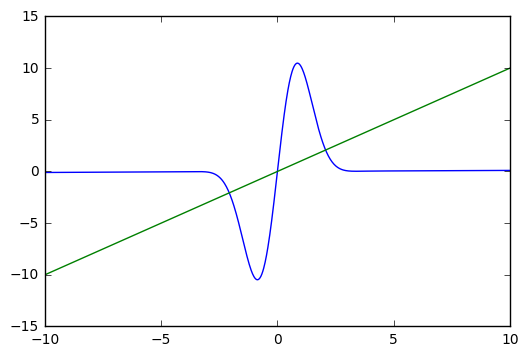

In [2]:
#Create the model

T = 500
np.random.seed(0)


# function 1 : Gabor filter
Q = np.identity(1) * 0.2
R = np.identity(1) * 0.2
f = lambda k,x_k: 0.01*x_k+20*np.sin(x_k)*np.exp(-x_k**2/2)

# function 2 : Well
Q = np.identity(1) * 1
R = np.identity(1) * 1
#f = lambda k,x_k: 0.9*x_k-50*np.exp(-x_k**2/2)+1

# function 3 : Sigmoid
Q = np.identity(1) * 1
R = np.identity(1) * 1
#f = lambda k,x_k:7*(1/(1+np.exp(-x_k))-0.5)

absc = np.linspace(-10,10,1000)
ordo = f(1,absc)

plt.figure()
plt.plot(absc,ordo)
plt.plot(absc,absc)
plt.show()

C=3
r=2

h = lambda k,x_k: C*x_k +r

B = np.zeros([1,1])
D = np.zeros([1,1])

mean = np.zeros([1,1])

x = np.zeros((T,1))
y = np.zeros((T,1))
u = np.zeros((T,1))

In [3]:
def extended_KF(x0,y,T,f,h,R,Q):

    #Initialization
    V = np.zeros([T,1])
    V[0] = np.identity(1)
    x_f = np.zeros([T,1])
    x_f[0] = x0
    
    V_plus_all = np.zeros([T,1])
    A_all = np.zeros([T,1])
    C_all = np.zeros([T,1])
    x_plus_all = np.zeros([T,1])

    #Propagation
    for k in range(1,T):   
        A_all[k-1] = np.matrix(partial_derivative(f,np.array([k-1,x_f[k-1]]))[1]) #derivative of f, with respect to x_k
        x_plus = f(k-1,x_f[k-1])
        x_plus_all[k] = x_plus
        C_all[k] = np.matrix(partial_derivative(h,np.array([k,x_plus]))[1]) #derivative of h, with respect to x_k
        V_plus = np.matrix(A_all[k-1].dot(V[k-1])).dot(A_all[k-1].T) + Q 
        V_plus_all[k] = V_plus

        K = V_plus.dot(C_all[k].T).dot(inv(C_all[k].dot(V_plus.dot(C_all[k].T)) + R))
        x_f[k] = x_plus + K.dot(y[k] - h(k,x_plus))
        V[k] = (np.identity(K.shape[0]) - K.dot(C_all[k])).dot(V_plus)

    A_all[T-1] = np.matrix(partial_derivative(f,np.array([T-1,x_f[T-1]]))[1]) #derivative of f, with respect to x_k

    #Recursive
    #F = A, B = H, P = V

    #Initialization
    x_b = np.zeros([T,1])
    x_b[T-1] = x_f[-1]
    V_b = np.zeros([T,1])
    V_b[-1] = V[-1]

    #Propagation
    #Remark: compared to the table 1.2 on page 17, we changed all the indexes by -1
    for k in range(T-1, 0, -1): #from T-1 to 1 by -1 increments

        A_b = np.matrix(V[k-1].dot(A_all[k].T)).dot(inv(np.matrix(V_plus_all[k])))
        V_b[k-1] = V[k-1] - A_b.dot(V_plus_all[k] - V_b[k]).dot(A_b.T)
        x_b[k-1] = x_f[k-1] + A_b.dot(x_b[k] - x_plus_all[k])
    
    return x_f,x_b

[ 0.17640523]
[ 9.23907255]
[ 0.10217811]
[ 0.94389191]
[ 0.15268851]
[-10.46113847]
[-0.0951105]
[-4.73608283]
[-0.04823002]
[ 6.64288953]
[ 0.06786933]
[ 6.28718086]
[ 0.07048219]
[ 3.75158822]
[ 0.03933613]
[ 6.80233262]
[ 0.08296412]
[-2.42089548]
[-1.88474516]
[-0.21162954]
[-0.18883051]
[ 8.05146841]
[ 0.08915905]
[-9.82482008]
[-0.07555065]
[-6.21545525]
[-0.06169696]
[-4.77864102]
[-0.02172817]
[ 6.97539135]
[ 0.07130339]
[ 7.85931642]
[ 0.06971531]
[-3.05518919]
[-0.01822759]
[ 2.72889223]
[ 0.0338342]
[ 8.81076713]
[ 0.0842344]
[-4.22739672]
[-0.05274423]
[-6.74358267]
[-0.08449853]
[ 3.37192207]
[ 0.12034525]
[-5.94382297]
[-0.07196618]
[ 10.11835343]
[ 0.08504456]
[-2.52757498]
[-0.0183698]
[ 6.73559484]
[ 0.06224789]
[-9.63564569]
[-0.09663828]
[ 6.16761213]
[ 0.06234129]
[ 6.67977083]
[ 0.06045443]
[-5.69119054]
[-0.06363651]
[-7.51414757]
[-0.08327294]
[-3.79803757]
[-0.02308112]
[-7.53669522]
[-0.09166894]
[ 6.77411956]
[ 0.05866794]
[ 2.19539925]
[ 0.08909931]
[ 4.2276

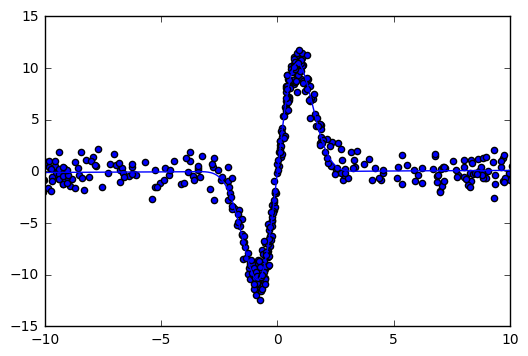

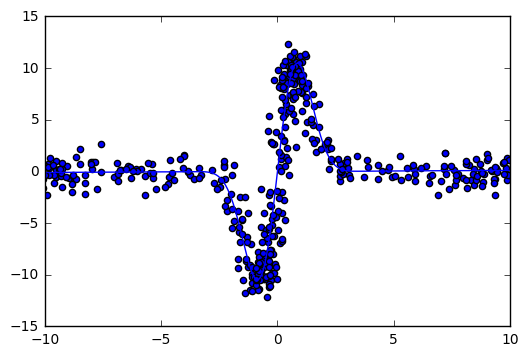

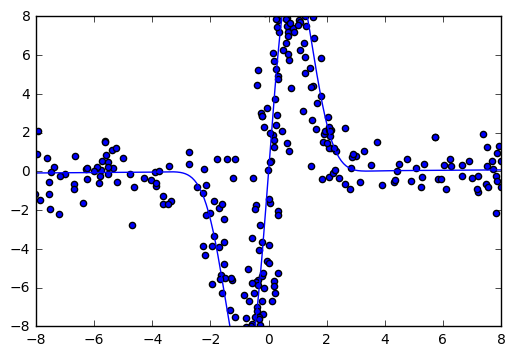

In [4]:
iterations = 1

x_it = np.zeros((iterations,T))
y_it = np.zeros((iterations,T))
x_f_it = np.zeros((iterations,T))
x_b_it = np.zeros((iterations,T))

for i in range(iterations):    
    x[0] = normal(0,10)

    #Propagation
    for k in range(T-1):
        print(f(k,x[k]))
        x[k+1] = f(k,x[k]) + np.dot(B,u[k]) + normal(mean,Q)
    for k in range(T):
        y[k] = h(k,x[k])  + np.dot(D,u[k]) + normal(mean,R)
        
    x_it[i] = x.flatten()
    y_it[i] = y.flatten()
    
    x_f,x_b = extended_KF(x[0],y,T,f,h,R,Q)
    
    x_f_it[i] = x_f.flatten()
    x_b_it[i] = x_b.flatten()
    
absc = np.linspace(-10,10,T)
ordo = f(1,absc)

plt.figure()
plt.plot(absc,ordo)
for i in range(iterations):
    plt.scatter(x_it[i,:-1],x_it[i,1:])
plt.xlim(-10,10)
#plt.savefig("graphs/x3.eps",format = "eps")
    
plt.figure()
plt.plot(absc,ordo)
for i in range(iterations):
    plt.scatter(x_f_it[i,:-1],x_f_it[i,1:])
plt.xlim(-10,10)
plt.ylim(-15,15)

plt.figure()
plt.plot(absc,ordo)
#plt.plot(absc,absc)
for i in range(iterations):
    plt.scatter(x_b_it[i,:-1],x_b_it[i,1:])
#plt.savefig("graphs/x3_b.eps",format = "eps")
plt.xlim(-8,8)
plt.ylim(-8,8)

plt.show()

In [5]:
def kmeans(x,k):
    n = x.shape[0]
    n_iterations = 1000
    epsilon = 1e-8
    err = np.inf

    #initialize random centroids
    c = np.zeros((k,2))
    for i in range(k):
        idx = np.random.randint(n)
        c[i] = x[idx,:]

    for iteration in range(n_iterations):
        d = np.zeros((n, k))  # distances to centroids square
        for i in range(k):
            d[:, i] = np.sqrt(np.sum(np.square(np.subtract(x, np.tile(c[i, :], (n, 1)))), 1).flatten())

        #assign each point to nearest centroid
        l = np.argmin(d,1)


        #recompute centroids as center of mass of each cluster
        for j in range(k):
            if len(l[l==j]):
                c[j,:] = x[l==j].sum(0) / len(l[l==j])

        err_new = np.sum(np.min(d,1))/n


        if np.abs(err_new - err)<epsilon:
            break
        err = err_new

    return c,l,err

In [6]:
def factor_analysis(X,m):
    #X is a d*n data matrix
    #m : dimension of target space (i.e reduced space)
    d = X.shape[0]
    n = X.shape[1]
    
    mu = np.mean(X, axis = 1)
    
    
    print(d)
    print(n)
    #Mu = dot(mu, np.ones((n,),"float"))
    
    CenteredData = X

    for i in range(n):
        for j in range(d):
            CenteredData[j,i] = X[j,i]-mu[j]
        
    
    #The tolerance value
    tol = 1e-4
    
    #Maximum number of iteration
    maxiter = 50
    
    #Log-likelihood value
    llh = -1
    
    #Define identity matrix 
    I = np.identity(m)
    
    M = dot(CenteredData, np.transpose(CenteredData))
    r = M.diagonal()
    
    #Initialize the weight matrix
    W = np.random.rand(d,m)
    Wupdated = W
    
    #Psi is the diagonal covariance matrix, we store only a d-dimensional vector
    Psi = np.identity(d)
    
    for i in  range(d):
        Psi[i,i] = random.random()
    
    Psiupdated = Psi
    
    for iter in range(maxiter-1):
        Psi = Psiupdated
        W = Wupdated
        G = inv(I + dot(dot(np.transpose(W),inv(Psi)),W))
        R = dot(dot(np.transpose(W), inv(Psi)),CenteredData)
        
        #E-step
        Ez = dot(G,R)
        Ezz = G + dot(Ez, np.transpose(Ez))
        
        #M-step
        DataCovariance = np.cov(CenteredData)
        
        #Updated weights
        Wupdated = dot(CenteredData, np.transpose(Ez))
        Wupdated = dot(Wupdated, inv(Ezz))
        
        #Updated Psi
        V = np.diag(DataCovariance - (1/n)**dot(Wupdated,dot(Ez,np.transpose(CenteredData))))
        Psiupdated = np.diag(V)
        #print(Psiupdated)
        
        
    L = [mu,Wupdated,Psiupdated]
    
    return L

In [7]:
#radial basis function compute exp(-beta * (c-x)^2)
def radialbasisfunc(beta, c, x):
    return np.sqrt(beta/pi)*exp(-beta * norm(c-x)**2)

def linearfunction(a,b,x):
    return a*x+b
     
#activation fills the Phi (in the pdf)
def activation(X, beta, numNeurons, centers):
    # calculate activations of RBFs
    Phi = zeros((X.shape[0], numNeurons), float)
    for i, c in enumerate(centers):
        for j, x in enumerate(X):
            #Here we fill the element j,i with exp(-beta * (c_i-x_j)^2)
            Phi[j,i] = radialbasisfunc(beta, c, x)
    return Phi
     
#trainrbf gives the values of the weights W and the covariance matrix Q
def trainrbf(X, Y, beta, numNeurons,linear):
    
    #Dimensions
    #X: n x Inputdimension
    #y: n x 1
    
    n = X.shape[0]
    
    #Centers are the neurons in our RBF network
    newCenters = kmeans(X,numNeurons)
    centers = newCenters[0]
    #centers = np.linspace(-8, 8, num=numNeurons)
    
    print "center", centers
    
    # calculate activations of RBFs
    if linear == 0:
        Phi = activation(X, beta, numNeurons, centers)
        Phi = np.append(Phi, X, axis =1)
        Phi = np.append(Phi, np.ones((n,X.shape[1]), "float"), axis = 1)
    else:
        Phi = X
        Phi = np.append(Phi, np.ones((n,X.shape[1]), "float"), axis = 1)
        
    # calculate output weights (pseudoinverse)
    W = dot(pinv(Phi), Y)
    
    #Calculate the covariance matrix Q with formula (6.18) 
    #Q = dot(np.transpose(Y),Y) - dot(np.transpose(W), dot(np.transpose(Phi), Y))
    Q=0
    for k in range(n-1):
        Q += (Y[k+1]- dot(Phi[k,:],W))*(Y[k+1]- dot(Phi[k,:],W))
    #Q = (1/(n-1))*Q
    
    L = [W, Q, centers]
    
   
    #print W
    print Q
    
    return L
         
def testrbf(X, W, Q, beta, numNeurons, centers):
    """ X: matrix of dimensions n x indim """
         
    Phi = activation(X, beta, numNeurons, centers)
    Phi = np.append(Phi, X, axis=1)
    Phi = np.append(Phi, np.ones((n,X.shape[1]), "float"), axis=1)
    Y = dot(Phi, W) + (1/X.shape[0])*random.normal(0, Q, X.shape[0])
    
    print Phi.shape[1]
    print W.shape[1]
    return Y

center [[-6.78787879 -6.78787879]
 [ 4.44444444  4.44444444]
 [-4.68686869 -4.68686869]
 [-7.91919192 -7.91919192]
 [ 2.82828283  2.82828283]
 [ 7.43434343  7.43434343]
 [-2.58585859 -2.58585859]
 [-4.04040404 -4.04040404]
 [-5.25252525 -5.25252525]
 [ 1.53535354  1.53535354]
 [-5.97979798 -5.97979798]
 [-0.64646465 -0.64646465]
 [ 3.63636364  3.63636364]
 [ 6.3030303   6.3030303 ]
 [-7.27272727 -7.27272727]
 [-6.3030303  -6.3030303 ]
 [ 0.72727273  0.72727273]
 [ 0.16161616  0.16161616]
 [-5.65656566 -5.65656566]
 [ 1.13131313  1.13131313]
 [-7.5959596  -7.5959596 ]
 [ 2.1010101   2.1010101 ]
 [-1.61616162 -1.61616162]
 [ 5.33333333  5.33333333]
 [-3.39393939 -3.39393939]]
[ 143.85603718]
27
1


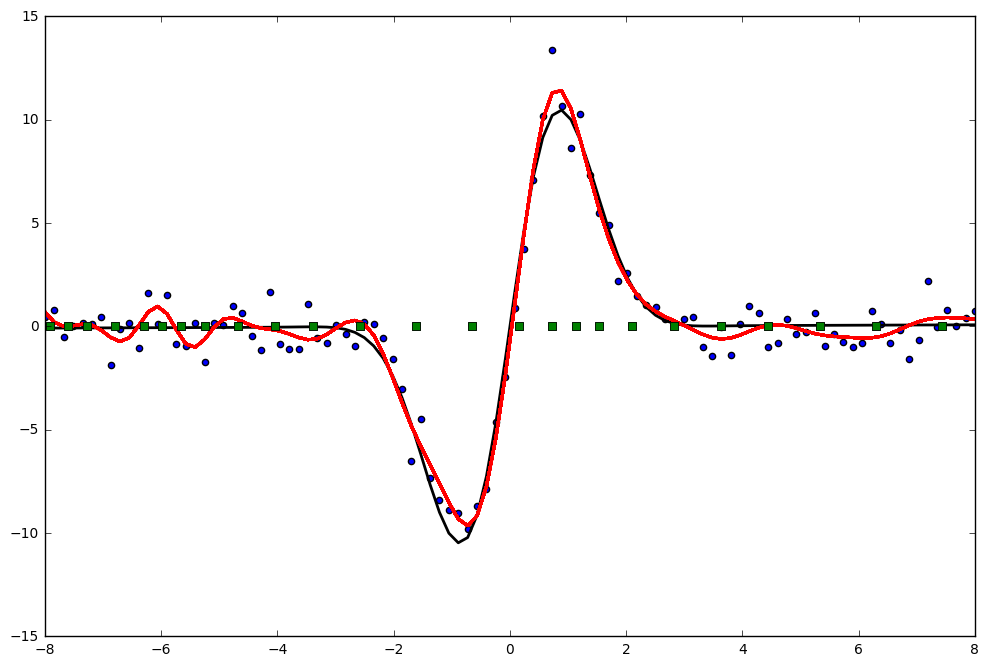

In [8]:
n = 100

#Specify Dimension of inputs and outputs
InputDimension = 1
OutputDimension = 1
     
#Define the bound of the focused interval    
lbound = -8
ubound = 8
    
x = mgrid[lbound:ubound:complex(0,n)].reshape(n, 1)
# set y and add random noise
    
    
#Function 1
yOriginal = 0.01*x+20*np.sin(x)*np.exp(-x**2/2)

# function 2 : Well
#yOriginal = 0.9*x-50*np.exp(-x**2/2)+1

yNoisy = yOriginal + random.normal(0, 1, yOriginal.shape)

     
#Initialize parameters of the radial basis function
    
#Number of Gaussian centers(Neurons)
numNeurons = 25

#Define the size of the kernels 
beta = 1

######### Start RBF regression #############
linear = 0
#Train the neural network on the data x
parameters = trainrbf(x, yNoisy , beta, numNeurons, linear)
z = testrbf(x, parameters[0], parameters[1], beta, numNeurons, parameters[2])
       
# plot original data
plt.figure(figsize=(12, 8))

# plot original data
plt.plot(x,yOriginal, 'k-', linewidth=2)

for i in range(n):
    plt.scatter(x[i], yNoisy[i])
     
# plot learned model
plt.plot(x, z, 'r-', linewidth=2)
     
# plot rbfs
plt.plot(parameters[2], zeros(numNeurons), 'gs')
     
plt.xlim(lbound, ubound)
plt.show()

#plt.savefig('graphs/RBF_2.png', format = 'png')

center [[  8.96768762   8.96768762]
 [  5.96302227   5.96302227]
 [-11.40732422 -11.40732422]
 [  1.97156715   1.97156715]
 [ -0.5596158   -0.5596158 ]
 [ -8.10601419  -8.10601419]
 [ -4.09016434  -4.09016434]
 [ -5.58785923  -5.58785923]
 [  3.44468645   3.44468645]
 [ -2.9481286   -2.9481286 ]
 [ 13.80954549  13.80954549]
 [-13.51377006 -13.51377006]
 [ 11.63515847  11.63515847]
 [ -1.68275939  -1.68275939]
 [  0.66673456   0.66673456]]
[ 29989.42468568]
center [[  7.91169916   7.91169916]
 [ -3.11274495  -3.11274495]
 [-10.85677863 -10.85677863]
 [ -1.70524717  -1.70524717]
 [  2.57147022   2.57147022]
 [  1.49748375   1.49748375]
 [ -4.90778784  -4.90778784]
 [ 10.42616742  10.42616742]
 [ -0.71568372  -0.71568372]
 [  0.426491     0.426491  ]
 [  3.70532446   3.70532446]
 [  5.67989869   5.67989869]
 [-13.16596025 -13.16596025]
 [ 12.93810942  12.93810942]
 [ -7.62249225  -7.62249225]]
[ 248163.8030111]
[ 2.2941948] [ 2.39271293]
[-2005.62878867]
center [[ 10.92724057  10.92724057

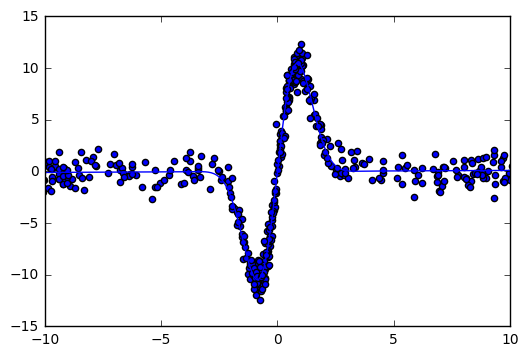

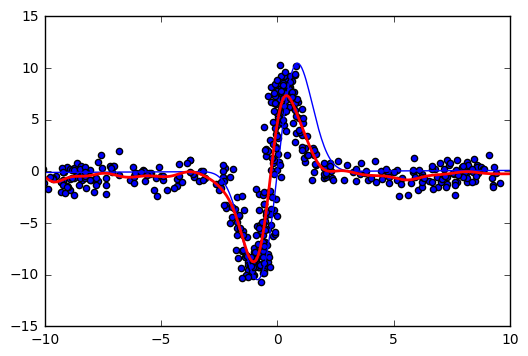

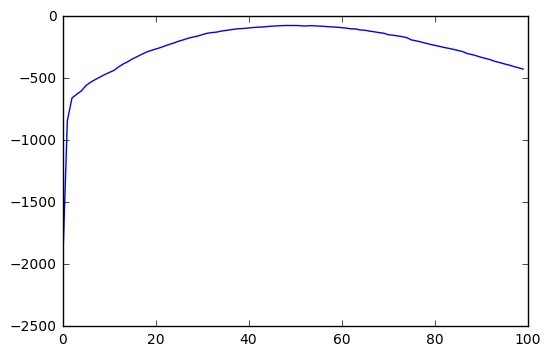

In [10]:
np.random.seed(0)
#EM algorithm

# x_k+1 = f(x_k) + w_k
# y_k = C*x_k + v_k

#Parameters of the sample which has to be inferred
mean = 0
Q=1
R=1

#x and y are the points we need to 
x = np.zeros((T,1))
y = np.zeros((T,1))


#We fix the number of kernel centers and the width of Gaussians

#Number of Gaussian centers(Neurons)
numNeurons = 15

#Define the size of the kernels 
beta = 1
Q_k=T
R_h=10

#Define the initial rbf with all weights equal to 1
W_k = np.ones(numNeurons+2)
centers = linspace(-8,8,numNeurons)

def f_rbf(k, x_k):
        u=0
        for i in range(numNeurons):
            u += np.sqrt(beta/pi)*exp(-beta * norm(centers[i]-x_k)**2) * W_k[i]
        u += x_k * W_k[numNeurons] + W_k[numNeurons+1]
        return u


W_h = np.array([2,3])
def h_rbf(k, y_k):
        return y_k * W_h[0] + W_h[1]


x[0] = normal(mean,Q)

#Propagation
for k in range(T-1):
    x[k+1] = f(k,x[k]) + normal(0,Q)
for k in range(T):
    y[k] = h(k,x[k]) + normal(0,R)

#Number of iterations 
maxIter = 20

#Log-likelihood
llh = np.zeros((maxIter,1)) 

#Start the EM algorithm
for t in range(maxIter):
    
    #E-Step
    
    #Input : f,C,Q,R, y_1, ..., y_T
    #Output : x_1,...,x_T
    
    
    iterations = 1

    x_f_it = np.zeros((iterations,T))
    x_b_it = np.zeros((iterations,T))

    for i in range(iterations):    
        
        #Start with the initial mean=0
        
        x[0] = normal(0,Q)
        
        #Infer the states with non-linear Kalman filter
        x_f,x_b = extended_KF(x[0],y,T,f_rbf,h_rbf,R,Q)
        
        x_it[i] = x.flatten()
        y_it[i] = y.flatten()
    
        x_f_it[i] = x_f.flatten()
        x_b_it[i] = x_b.flatten()
        
    #M-Step
    
    #Input : x_1, ..., x_T, y_1,..., y_T
    #Output : f,C,Q,R.
    
    #############################Fitting Input dynamics######################## 
    
    #Learn the state parameters
    
    #X represents x_k
    #Y represents x_{k+1}
    
    X = x_f[0:T-2]
    Y = x_f[1:T-1]
    
    #Train the rbf and learn the new parameters
    StateParameters = trainrbf(X,Y, beta, numNeurons,0)
    
    W_k = StateParameters[0]
    Q_k = StateParameters[1]
    centers = StateParameters[2]
    
    #Update the Radial basis function with the new centers and the new weights
    def f_rbf(k, x_k):
        u=0
        for i in range(numNeurons):
            u += np.sqrt(beta/pi)*exp(-beta * norm(centers[i]-x_k)**2) * W_k[i]
        u += x_k * W_k[numNeurons] + W_k[numNeurons+1]
        return u
    
    ############################################################################
    
    #############################Fitting Output dynamics######################## 
    
    X = x_f[0:T-1]
    Y = y[0:T-1]
    
    #Train the rbf and learn the new parameters
    OutputParameters = trainrbf(X,Y, beta, numNeurons,1)
    
    W_h = OutputParameters[0]
    R_h = OutputParameters[1]
    
    print W_h[0], W_h[1]
    
    def h_rbf(k, y_k):
        return y_k * W_h[0] + W_h[1]
    
    llh[t] = np.sum(np.array([(-1/2)*(x[1:T-1]-x_f[1:T-1])**2]))
    
    print(llh[t])
    
    #############################################################################

absc = np.linspace(-15,15,T)
ordof = f(1,absc)
ordorbf = np.zeros(T)
for i in range(T):
    ordorbf[i] = f_rbf(1,absc[i])
    
#Plot the real states and the real function
plt.figure()
plt.plot(absc,ordof)
for i in range(iterations):
    plt.scatter(x_it[i,:-1],x_it[i,1:])
plt.xlim(-10,10)
#plt.ylim(-25,25)

#Plot the infered states and the corresponding radial basis function
plt.figure()
plt.plot(absc,ordof)
plt.plot(absc,ordorbf, 'r-', linewidth=2)
for i in range(iterations):
    plt.scatter(x_f_it[i,:-1],x_f_it[i,1:])
plt.xlim(-10,10)
#plt.ylim(-25,25)

plt.figure()
plt.plot(range(maxIter),llh)


        
plt.show()

plt.savefig('graphs/RBF_EM.png', format = 'png')